# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [ ]:
# import libraries
import os
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader as dl
import src.visualization as vis
import src.net_models as net
import src.input_preparation as ip

#### Beispiel für ein Diagramm im Markdown

```mermaid
flowchart TD
    Start --> Stop
```


In [ ]:
# set the source directory for the preprocessed data to use
SOURCE: str = "f2fcf2aa-bd96-4d89-8bb5-4a0a1bc11b1b"

# setup a single index for control purposes
CONTROL_INDEX: int = 0

In [3]:
# setup system and check the number of cpu cores and gpus available
net.system_setup()

Number of CPU cores:		20
Number of GPUs available:	0


#### **Laden der Datensätze**

Üblicherweise werden für das Training eines neuronalen Netzes mittels Supervised Learning die Daten in mindestens zwei separate Datensätze aufgeteilt: einen Trainings- und einen Testdatensatz. Mit dem Testdatensatz können nach dem Training zukünftige (dem Netz unbekannte) Dateneingaben simuliert werden und so vorab die Zuverlässigkeit des Trainings beurteilt werden (Liu, 2025, S. 39).
Nach dem Laden der Daten aus dem *data*-Ordner werden CSV-Dateien mit der Endung *D* in der Liste *development_data* und Dateien mit der Endung *E* in der Liste *evaluation_data* gespeichert.

In [4]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

load_all_datasets():
	Reading development data ...
	0D_0_fft.csv successfully loaded.
	0D_1_fft.csv successfully loaded.
	1D_0_fft.csv successfully loaded.
	1D_1_fft.csv successfully loaded.
	2D_0_fft.csv successfully loaded.
	2D_1_fft.csv successfully loaded.
	3D_0_fft.csv successfully loaded.
	3D_1_fft.csv successfully loaded.
	4D_0_fft.csv successfully loaded.
	4D_1_fft.csv successfully loaded.
	Reading evaluation data ...
	0E_0_fft.csv successfully loaded.
	0E_1_fft.csv successfully loaded.
	1E_0_fft.csv successfully loaded.
	1E_1_fft.csv successfully loaded.
	2E_0_fft.csv successfully loaded.
	2E_1_fft.csv successfully loaded.
	3E_0_fft.csv successfully loaded.
	3E_1_fft.csv successfully loaded.
	4E_0_fft.csv successfully loaded.
	4E_1_fft.csv successfully loaded.
	Reading completed.



Exemplarisch wird ein Datensatz aus den Development-Daten in mehreren Subplots visualisiert, um sicherzustellen, dass die Daten korrekt geladen wurden. 

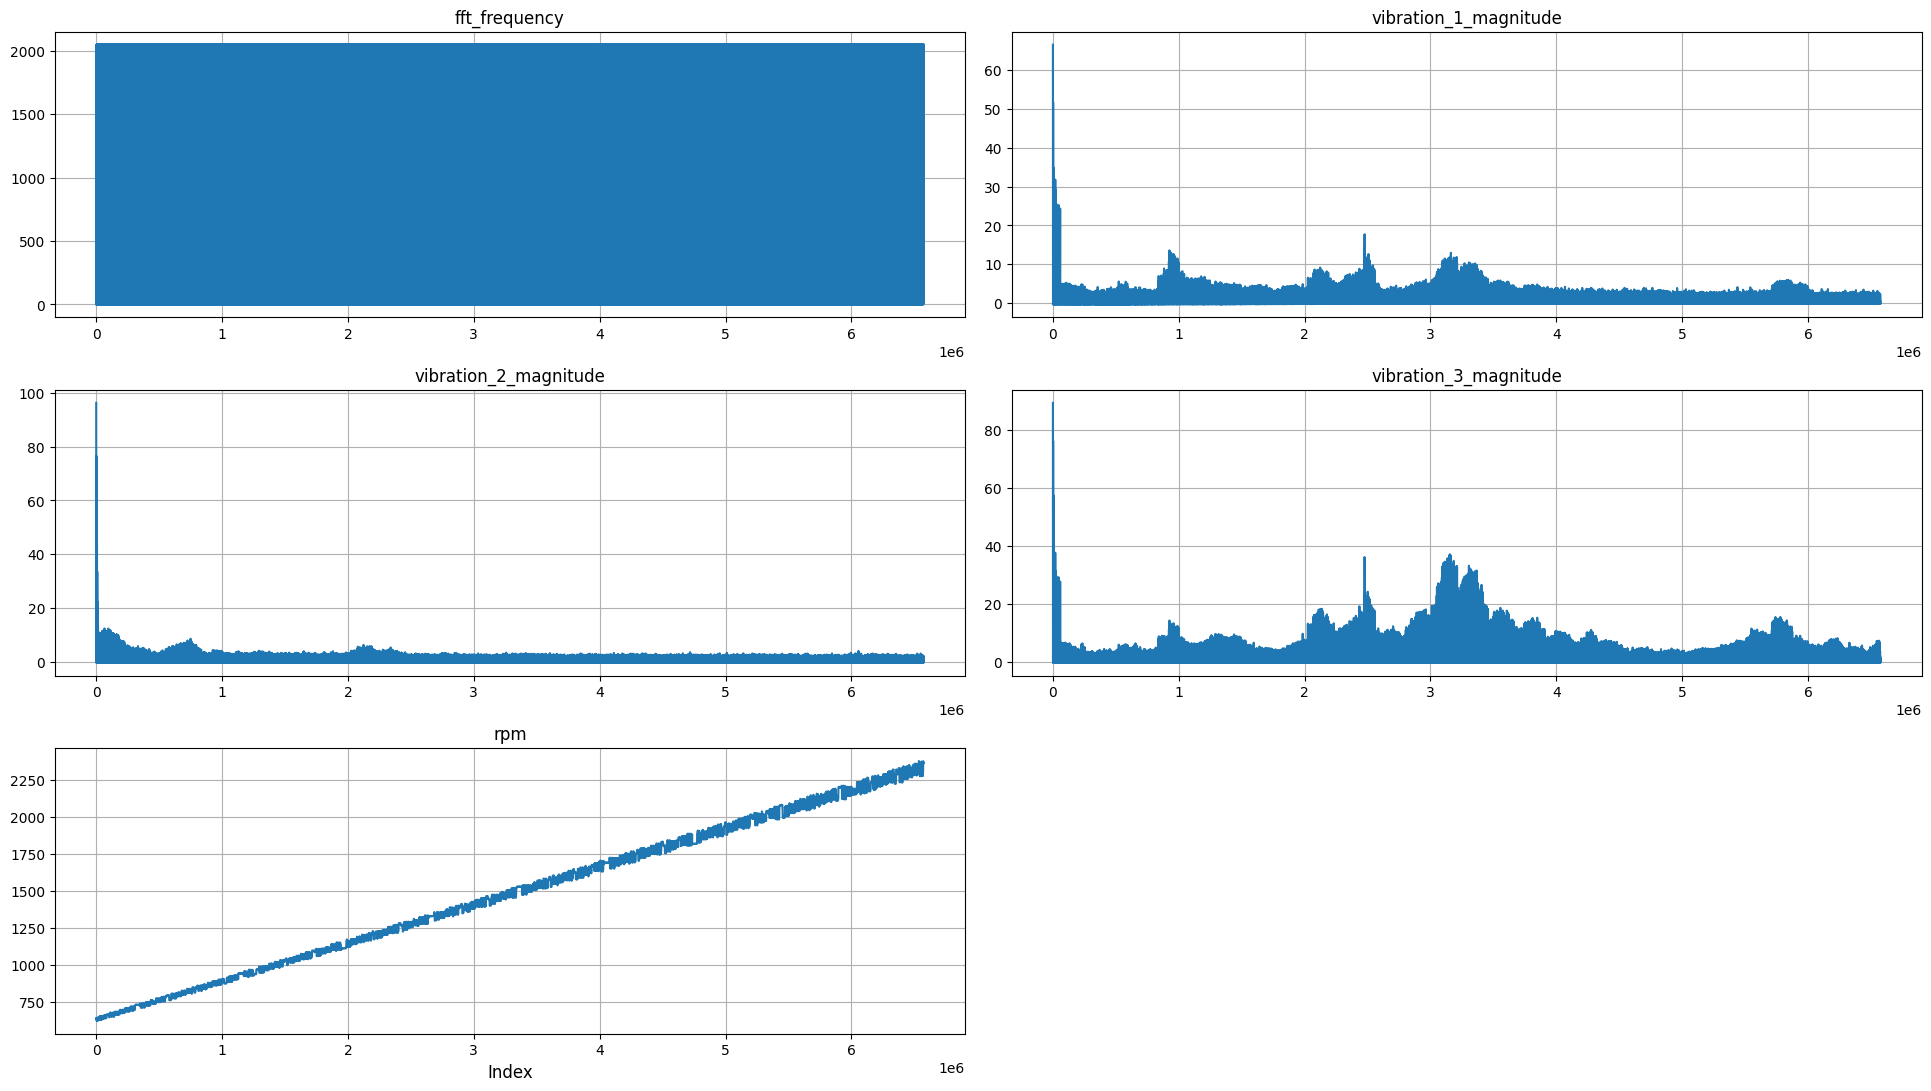

In [5]:
# visualize one random dataset for data validation
vis.plot_column_data(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Vorbereitung der Daten zur Eingabe in das neuronale Netz**

Um das neuronale Netz trainieren zu können, ist eine Aufbereitung der Trainings- und Testdaten erforderlich.
Dazu werden die einzelnen DataFrames mit den Trainingsdaten zu einem einheitlichen DataFrame zusammengeführt. Gleichzeitig wird eine zusätzliche Spalte *Label* erstellt, welche die gemessenen Unwuchtstärken (*none*, *slight*, *moderate*, *significant* und *strong*) enthält und somit als *Output* für die spätere Klassifizierung dient (Liu, 2025, S.19). Die Labels werden in das One-Hot-Encoding-Format überführt, welches für die Multiklassen-Klassifizierung in Deep-Learning-Systemen benötigt wird (Liu, 2025, S.74).
Anschließend werden die DataFrame-Spalten mit den Amplituden der Vibrationen als *Input* (Features) für das NN spezifiziert.

(If Bedingung Binary Label)

In [6]:
full_development_dataset = ip.concatenate_datasets(development_data)

training_samples_dict = ip.split_data(
    dataframe=full_development_dataset,
    data_columns=[
        "vibration_1_magnitude",
        # "vibration_2_magnitude",
        # "vibration_3_magnitude",
    ],
)

print(training_samples_dict["labels"].shape)
print(training_samples_dict["samples"].shape)

(32148, 5)
(32148, 2048)


Mit dem Aufruf der Funktion `ckeck_data` werden die im vorbereiteten Datensatz enthaltenen Klassen sowie deren jeweilige Häufigkeiten überprüft, um einen Überblick über die Verteilung der verschiedenen Labels im Trainingsdatensatz zu gewinnen. Es ist wichtig eine ausgewogene Klassen-Verteilung sicherzustellen, da eine ungleiche Verteilung zu Bias und damit zu ungenauen Vorhersagen führen kann (Liu, 2025, S.36).

In [7]:
ip.check_data(training_samples_dict)


check_data():

	Class 'moderat':	6430.0 samples
	Class 'none':	6430.0 samples
	Class 'significant':	6429.0 samples
	Class 'slight':	6430.0 samples
	Class 'strong':	6429.0 samples


#### **Das Neuronale Netz**

In [ ]:
# model creation parameters
N_HIDDEN_LAYERS: int = 4
L2: float = 1e-3 # 0.001
DROPOUT: float = 0.3
NEGATIVE_SLOPE: float = 0.3

# model compilation parameters
LEARNING_RATE: float = 1e-4

# model training parameters
BATCH_SIZE: int = 64
EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.1

# manual changes to class weights
training_samples_dict["class_weights"] = {
    0: 0.7,  # none (Klasse 0) wird weniger stark gewichtet
    1: 2.5,  # slight (Klasse 1) wird stärker gewichtet
    2: 1.5,  # moderate (Klasse 2) wird leicht erhöht
    3: 1.2,  # significant (Klasse 3) bleibt gleich
    4: 0.7   # strong (Klasse 4) wird weniger stark gewichtet
}

In [9]:
model = net.multiclass_classifier.build_model(
    n_hidden_layers=N_HIDDEN_LAYERS,
    training_samples_dict=training_samples_dict,
    l2=L2,
    dropout=DROPOUT,
    negative_slope=NEGATIVE_SLOPE,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,448,453 (36.04 MB)

 Trainable params: 9,448,453 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

- warum diese Parameter erklären

In [ ]:
net.multiclass_classifier.compile(model=model, learning_rate=LEARNING_RATE)

history = net.train(
    model=model,
    samples_dict=training_samples_dict,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    use_early_stopping=True,
)

#### **Bewertung des Neuronalen Netzes**

In [ ]:
# visualize training metrics
vis.plot_history(history, metrics=["loss", "accuracy", "precision", "recall"])

In [ ]:
full_evaluation_dataset = ip.concatenate_datasets(evaluation_data)

test_samples_dict = ip.split_data(dataframe = full_evaluation_dataset, data_columns = [
        "vibration_1_magnitude",
        # "vibration_2_magnitude",
        # "vibration_3_magnitude",
    ],
)

In [ ]:
ip.check_data(test_samples_dict)

In [ ]:
# evaluate model
evaluation = net.evaluate(model=model, test_samples_dict=test_samples_dict, batch_size=BATCH_SIZE)
display(evaluation)

### Confusion Matrix
Die Confusion Matrix zeigt, wie gut dein Modell zwischen den verschiedenen Klassen unterscheidet. Jede Zelle stellt die Anzahl der Samples dar, die einer bestimmten Klasse zugeordnet wurden (wahre Labels) und wie das Modell diese Klasse vorhergesagt hat (vorhergesagte Labels).



In [ ]:
# predictions by model
true_labels, predicted_labels = net.predict(model=model, test_samples_dict=test_samples_dict)

# plot confusion matrix
vis.plot_confusion_matrix(true_labels=true_labels,
                          predicted_labels=predicted_labels,
                          class_names=test_samples_dict["encoder"].classes_.tolist()
                          )



Liu, Z.“. (2025). Deep Learning. In: Artificial Intelligence for Engineers. Springer, Cham. https://doi.org/10.1007/978-3-031-75953-6_8